In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

from experiments.result_buckets import gpt3_curie, bilstm, roberta_specialized, roberta_unified, specialized_full_input_lexical

%load_ext autoreload
%autoreload 2

100%|███████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 36962.04it/s]


In [2]:
snli_results = {
    'specialized_full_input_lexical': specialized_full_input_lexical['snli-human'],
    'bilstm': bilstm['snli-human'],
    'specialized_roberta': roberta_specialized['snli-human'],
    'unified_roberta':  roberta_unified['snli-human'],
    'gpt3-curie': gpt3_curie['snli-human'],
    
}

test_results_snli = {
    'specialized_roberta': roberta_specialized['snli-test'],
    'unified_roberta':  roberta_unified['snli-test'],
    'specialized_full_input_lexical': specialized_full_input_lexical['snli-test'],
    'gpt3-curie': gpt3_curie['snli-test'],
    'bilstm': bilstm['snli-test'],
}
    

In [3]:
import seaborn as sns

specialized_full_input_lexical
Prop explained: 0.6420444614924627
Total variance: 0.24864069992857876
Test set accuracy: 0.5574305933587371
paraphrase acc: 0.5368686868686868
variance of bernoulli with acc: 0.2486406999285787

#### Old Metrics ####
Unweighted consistency: 0.7896619047619047
Weighted consistency: 0.775510453009061

bilstm
Prop explained: 0.4561960103182316
Total variance: 0.2441840118355269
Test set accuracy: 0.6804572672836146
paraphrase acc: 0.5762626262626263
variance of bernoulli with acc: 0.244184011835527

#### Old Metrics ####
Unweighted consistency: 0.7037396825396826
Weighted consistency: 0.7300803424735418

specialized_roberta
Prop explained: 0.4938082810751717
Total variance: 0.24852668095092342
Test set accuracy: 0.8671747414262384
paraphrase acc: 0.5383838383838384
variance of bernoulli with acc: 0.24852668095092337

#### Old Metrics ####
Unweighted consistency: 0.7052253968253969
Weighted consistency: 0.9064806546026608

unified_roberta
Prop explained: 0.5

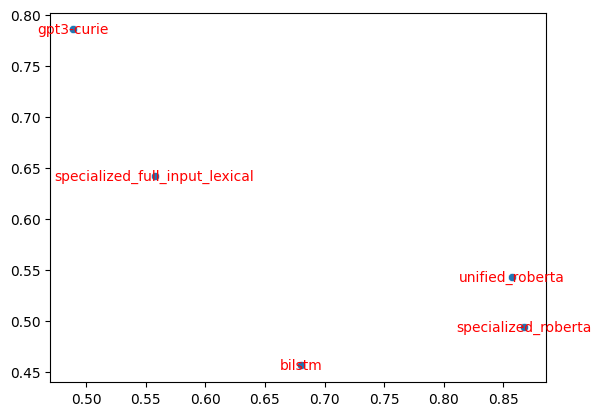

In [6]:
from simple_colors import *
import matplotlib.pyplot as plt
x = []
y = []
names = []

for model, analysis in snli_results.items():
    print(green(model))
    variance_law = analysis.law_of_total_variance_breakdown()
    test_set_accuracy = test_results_snli[model].accuracy

    print('Prop explained:', variance_law['prop_explained'])
    print('Total variance:', variance_law['total_var_y'])
    print('Test set accuracy:', test_set_accuracy)
    print('paraphrase acc:', analysis.paraphrase_accuracy())
    print('variance of bernoulli with acc:', (analysis.paraphrase_accuracy() * (1-analysis.paraphrase_accuracy())))

    print("\n#### Old Metrics ####")
    
    print('Unweighted consistency:', analysis.mean_unweighted_consistency)
    print('Weighted consistency:', analysis.calculate_weighted_consistency(test_results_snli[model]))
    
    print()
    x.append(test_set_accuracy)
    y.append(variance_law['prop_explained'])
    names.append(model)

sns.scatterplot(x=x, y=y)
for i in range(len(names)):
    plt.text(x[i], y[i], names[i], fontsize=10, ha='center', va='center', color='red')
